In [2]:

import glob
import trimesh
import numpy as np
from tensorflow import keras
from keras import layers,optimizers,models
from matplotlib import pyplot as plt
import os
from glob import glob
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# tf.random.set_seed(1234)

# folders.glob(class_name[0])

# print(glob.glob(os.path.join(folders,class_name[0]+"/*")))
# print(glob.glob(os.path.join(folders,class_name[0]+"/*")))
file_path = glob('PointNet Train/*')

def valve_parse_dataset(num_points=2048):
    CLASS_MAP = []
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    # li = list(glob.glob(os.path.join(file_path,path,"*")))
    # 클래스 이름 정해주기
    
    for i, folder in enumerate(file_path):
        # li_path = folder.split('\\')
        li_path = folder.split("\\")
        CLASS_MAP.append(li_path[-1])
        print("Processing... (클래스 이름) : {}".format(li_path[-1]))
        train_files = glob(os.path.join(folder,"train/*"))
        test_files = glob(os.path.join(folder,'test/*'))
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    
    return (np.array(train_points),
            np.array(test_points),
            np.array(train_labels),
            np.array(test_labels),
            CLASS_MAP)

NUM_POINTS = 2048
NUM_CLASSES = 3
BATCH_SIZE = 128

train_points, test_points, train_labels, test_labels, CLASS_MAP = valve_parse_dataset(
    NUM_POINTS
)

# import matplotlib.pyplot as plt 

# for i in range(len(CLASS_MAP)):
#     sample = train_points[i]
#     sample_label = train_labels[i]
#     sample_label = CLASS_MAP[sample_label]
#     fig = plt.figure(figsize=(5, 5))
#     ax = fig.add_subplot(111, projection="3d")
#     ax.scatter(sample[:,0],sample[:,1],sample[:,2])
#     ax.set_axis_off()

# plt.show()



Processing... (클래스 이름) : DC_FLANGE
Processing... (클래스 이름) : REDUCER
Processing... (클래스 이름) : VALVE


In [3]:
def augment(points, label):
    # jitter points
    print(points.shape)
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

(2048, 3)


In [4]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("sigmoid")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("sigmoid")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [5]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

Epoch 1/15
1/1 [==============================] - 5s 5s/step - loss: 2.7200 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.2876 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/15
1/1 [==============================] - 1s 802ms/step - loss: 2.5358 - sparse_categorical_accuracy: 0.3571 - val_loss: 1.4320 - val_sparse_categorical_accuracy: 0.2500
Epoch 3/15
1/1 [==============================] - 1s 826ms/step - loss: 2.1639 - sparse_categorical_accuracy: 0.4286 - val_loss: 1.6964 - val_sparse_categorical_accuracy: 0.2500
Epoch 4/15
1/1 [==============================] - 1s 818ms/step - loss: 2.0954 - sparse_categorical_accuracy: 0.4286 - val_loss: 1.2869 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/15
1/1 [==============================] - 1s 824ms/step - loss: 1.6344 - sparse_categorical_accuracy: 0.5714 - val_loss: 1.2867 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/15
1/1 [==============================] - 1s 842ms/step - loss: 1.9986 - sparse_categorical_accuracy: 0.5

(<Figure size 1000x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot: title={'center': 'Sparse Categorical accuracy'}, xlabel='Epochs', ylabel='Sparse Categorical accuracy'>],
       dtype=object))

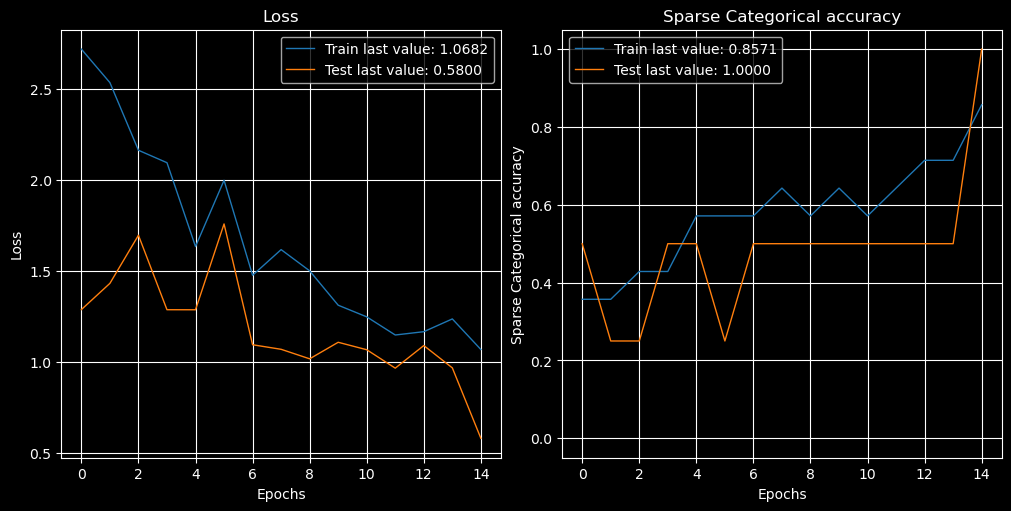

In [6]:


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer= 'adam',
    metrics=["sparse_categorical_accuracy"],
)



history = model.fit(train_dataset, epochs=15,validation_data=test_dataset)


from plot_keras_history import show_history, plot_history

# pd.DataFrame(history.history).plot(figsize=(12,5))
# plt.show()

plot_history(history.history)

# plt.plot(history.history['loss'],label='loss')
# plt.plot(history.history['val_loss'],label = 'val_loss')
# plt.legend()
# plt.show()





1/1 [==============================] - 0s 420ms/step
tf.Tensor([2 2 0], shape=(3,), dtype=int64)


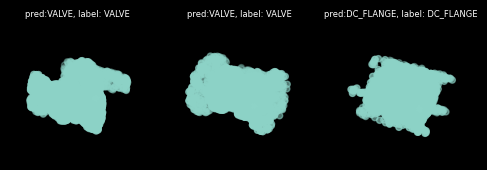

In [7]:

data = test_dataset.take(3)

points, labels = list(data)[0]

points = points[:NUM_CLASSES, ...]
labels = labels[:NUM_CLASSES, ...]

# run test data through model
preds = model.predict(points)

preds = tf.math.argmax(preds, -1)
print(preds)
points = points.numpy()
# plot points with predicted class and label
fig = plt.figure(figsize=(8, 5))

for i in range(len(CLASS_MAP)):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred:{:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels[i].numpy()]
        ),fontdict={'fontsize':6})
    ax.set_axis_off()
plt.show()